### 02 LangGraph/LangChain によるLLMチャット
- Google Colabに必要なライブラリをインストール
- transformersを使ってLLMモデルをHugging Faceから読み込み
- LangGraphによるLLMのメモリ管理
- LangGraph/LangChainによるチャット
- MCPサーバ(ddg-search)によるweb検索（今回（notebook 02）はユーザがMCPサーバを実行）

**Google Colabに必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
  > （transformersとlangchain-huggingfaceで、huggingface-hubのバージョンが衝突する等）
- NOTE: Colab では uv ではなく pip を使う。
  > uv は依存解決の過程でnumpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [1]:
# Google Colabに必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# 分割すると後勝ちで依存関係が壊れるリスクがある。
# （transformersとlangchain-huggingfaceで、huggingface-hubのバージョンが衝突する等）
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
%pip install -U transformers accelerate bitsandbytes \
     langchain langchain-huggingface langgraph \
     duckduckgo-mcp-server mcp

INFO: pip is looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to r

**transformersを使ってLLMモデルをHugging Faceから読み込み**

##### LLM バックエンドの選定

このリポジトリでは **transformers + bitsandbytes** を採用。
- Colab GPU との相性が良い
- 量子化などの細かい設定が可能
- 非同期処理に対応

**将来の本番環境向け:**
- 非同期/スケーラビリティ重視が必要となる場合、Ollamaなどサーバ管理されたものを使用する。

In [12]:
# transformersを使ってLLMモデルをHugging Faceから読み込みする。
import torch  # type: ignore
from transformers import (  # type: ignore
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,  # noqa: F401
    pipeline,
)  # type: ignore
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace  # type: ignore

model_name = "unsloth/gemma-3-1b-it"  # Hugging Faceのモデルの名称

# LLMモデルの量子化の設定
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,  # 4 ビットに量子化された形式で読み込むように指定
#     bnb_4bit_quant_type="nf4",  # 4 ビット量子化のデータ型として NF4 を指定
#     bnb_4bit_use_double_quant=True,  # 二重量子化の指定
#     bnb_4bit_compute_dtype=torch.bfloat16,  # 計算時のデータ型を指定
# )

# LLMに生成させる文章の計算条件
generation_params = {
    "do_sample": True,
    "temperature": 0.8,
    "top_k": 40,
    "top_p": 0.9,
    "repetition_penalty": 1.1,
    "max_new_tokens": 512,
}

# LLMモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Hugging Faceから読み込みするモデルの名称
    # quantization_config=quantization_config,
    dtype=torch.bfloat16,  # 読み込みするモデルのデータ型（transformers 4.x では torch_dtype）
    device_map="auto",  # 読み込んだモデルを CPU / GPUに自動で割り当てする指示
)

# transformersのパイプライン
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,  # 入力プロンプトを出力に含めない
)

# LangChainのHuggingFaceパイプラインに接続
llm = HuggingFacePipeline(pipeline=hf_pipeline, pipeline_kwargs=generation_params)

# チャットモデルインターフェースとして接続（チャットテンプレート対応）
chat_llm = ChatHuggingFace(llm=llm)

# モデルのメモリ消費量（バイト）を取得し、GBに変換して表示
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_gb = memory_footprint_bytes / (1024 * 1024 * 1024)
print(f"モデルのメモリ消費量: {memory_footprint_gb:.2f} GB")

Loading weights:   0%|          | 0/340 [00:00<?, ?it/s]

モデルのメモリ消費量: 1.86 GB


**LangGraphによるLLMのメモリ管理**
- chat_nodeで、前のセルで作成したLLMモデルを呼び出した際の処理を設定。
  > 今回は人間のプロンプトをLLMに入力して、LLMから応答を取得する処理。
- LangGraphのグラフを構築し、ノードとエッジを設定し、グラフをcompileする。
  > 今回は単純だが、各処理をつなげて自動化させる場合に効果を発揮する。
- InMemorySaverを使用して、LLMとの会話をメモリに保存させる。
  > LLMとのチャット履歴が保持されるようになる。
- 作成したグラフを図示する。

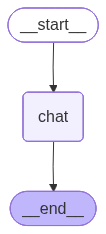

In [13]:
# LangGraph によるメモリ付きチャットグラフの構築
# InMemorySaver を使って、スレッド（thread_id）ごとに会話履歴を保持する
from langgraph.graph import StateGraph, MessagesState, START, END  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from IPython.display import Image, display


# チャットノード：現在の会話履歴を LLM に送信し、返答を生成
def chat_node(state: MessagesState):
    response = chat_llm.invoke(state["messages"])
    return {"messages": [response]}


# グラフの構築
graph = StateGraph(MessagesState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()
app = graph.compile(checkpointer=memory)

# 構築したグラフを図示
display(Image(app.get_graph().draw_mermaid_png()))

**LangGraph/LangChainによるチャット**
- SystemMessageでシステムプロンプトを、HumanMessageでユーザのプロンプトを設定する。
- configで指定したthread_idごとに会話履歴が保持される。
- 2回目の質問で前の会話を踏まえた回答が返れば、メモリが正常に動作している証拠。

In [4]:
# マルチターン会話のテスト
# 同じ thread_id でLLMを複数回呼び出すと、会話履歴が自動的に保持される
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

config = {"configurable": {"thread_id": "thread_1"}}

# 1回目の質問（システムプロンプト付き）
response1 = app.invoke(
    {
        "messages": [
            SystemMessage(content="日本語で回答してください。"),
            HumanMessage(content="私はジョンです。日本で一番高い山は？"),
        ]
    },
    config=config,
)
print("=== 1回目の返答 ===")
print(response1["messages"][-1].content)

# 2回目の質問（前の会話を踏まえて回答できれば、メモリが動作している証拠）
response2 = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="私の名前は何ですか？先ほど答えた山の高さは何メートルですか？"
            ),
        ]
    },
    config=config,
)
print("\n=== 2回目の返答 ===")
print(response2["messages"][-1].content)

=== 1回目の返答 ===
日本で一番高い山は富士山です。

富士山は、山梨県と静岡県にまたがっています。標高は3,776.24mです。

=== 2回目の返答 ===
私の名前はAIです。

先ほど答えた山の高さは3,776.24メートルです。


**MCPサーバ（duckduckgo-mcp-server）によるWeb検索**
- MCPサーバ（duckduckgo-mcp-server）を stdio 経由で起動し、検索ツールを取得する。
  > AIに自律的に検索ツールを使わせるのではなく、今回（notebook 02）はユーザがMCPサーバを実行。
- 検索結果をコンテキストとして LLM に渡し、回答を生成させる。
  > gemma-3-1b はツールコール非対応のため、検索→LLM回答の2段構成とする。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**stdio_client接続の補足**

async with stdio_client(server_params) as (read, write):を、次に修正している。
  > async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):

これはColab環境特有の処置で、Colabの内部構造が標準的なstderrに対応していないため。

In [ ]:
# MCPサーバ（duckduckgo-mcp-server）に接続して検索し、結果をLLMに渡す
# Colab環境ではasyncioのインポートなしで非同期処理（async/await）が使用可能
# 通常のPython環境では、asyncioのインポートが必要
import os

from mcp import ClientSession, StdioServerParameters  # type: ignore
from mcp.client.stdio import stdio_client  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

# MCPサーバへの接続パラメータ（stdio 経由で起動）
server_params = StdioServerParameters(
    command="duckduckgo-mcp-server",
    args=[],
)

query = "2025年 日本の総人口"

# MCPサーバに接続し、検索ツールを取得して実行
# NOTE: Colab の stderr は fileno() 未対応のため、errlog をファイルに迂回する
async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):
    async with ClientSession(read, write) as session:
        await session.initialize()

        # MCPサーバが提供するツール一覧を表示
        tools = await session.list_tools()
        print("=== 利用可能なツール ===")
        for t in tools.tools:
            print(f"  - {t.name}: {t.description}")

        # 検索ツールを実行（max_results で検索結果数を制限）
        result = await session.call_tool("search", {"query": query, "max_results": 3})

# 検索結果を取得
search_results = result.content[0].text
print("\n=== 検索結果 ===")
print(search_results)

# 検索結果をコンテキストとしてLLMに質問
config = {"configurable": {"thread_id": "thread_search"}}
response = app.invoke(
    {
        "messages": [
            SystemMessage(
                content="以下の検索結果をもとに、ユーザの質問に日本語で簡潔に回答してください。"
            ),
            HumanMessage(content=f"質問: {query}\n\n検索結果:\n{search_results}"),
        ]
    },
    config=config,
)
print("\n=== LLMの回答 ===")
print(response["messages"][-1].content)